In [1]:
import os
import os.path as osp
import json
import tempfile
from cvutils.mrcnn.session import init_keras_session
from celldom.preprocessing import apartment_extraction, cell_extraction
from celldom.application import cell_quantification
from celldom.dataset import marker_dataset
from cvutils.mrcnn import model as mrcnn_model
from celldom.config import cell_config, marker_config
from skimage import io as sk_io
from celldom import seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

init_keras_session()
plt.gray()

chip_config_path = osp.join(os.environ['CELLDOM_REPO_DIR'], 'config', 'chip_01_config.json')
digit_model_path = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.2', 'digit_model', 'tune', 'single_digit_model.h5')
cell_model_path = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.2', 'cell_model', 'cell_model.h5')
marker_model_path = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.2', 'marker_model', 'marker_model.h5')
data_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'dataset03')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
chip_config = json.load(open(chip_config_path, 'r'))

In [35]:
import imp
imp.reload(cell_extraction)
imp.reload(cell_quantification)
imp.reload(apartment_extraction)

<module 'celldom.preprocessing.apartment_extraction' from '/lab/repos/celldom/python/source/celldom/preprocessing/apartment_extraction.py'>

In [3]:
digit_model = keras.models.load_model(digit_model_path)

marker_model = mrcnn_model.get_model(
    'inference', marker_config.MarkerInferenceConfig(), tempfile.mkdtemp(), 
    init_with='file', file=marker_model_path
)

cell_model = mrcnn_model.get_model(
    'inference', cell_config.CellInferenceConfig(), tempfile.mkdtemp(), 
    init_with='file', file=cell_model_path
)

In [4]:
data_files = cell_quantification.get_dataset_files(data_dir, pattern='2018*MOLM13*Chip2/*.tif')
data_files.head()

,address,cells,chip,cohort,conc,date,day,filename,folder,path,z
6,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_z_0.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31...,z_0
0,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zm3.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31...,zm3
1,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zm6.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31...,zm6
2,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zm9.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31...,zm9
3,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zp3.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31...,zp3


In [5]:
import tqdm

def process(record, save_images=False):
    # Prepare single image dataset
    dataset = marker_dataset.MarkerDataset()
    dataset.initialize([record['path']])
    dataset.prepare()
    image = dataset.load_image(0)
    
    # Extract all relevant information
    partitions, norm_image, norm_centers, neighbors, rotation, scale = apartment_extraction.extract(
        image, marker_model, chip_config, 
        digit_model=digit_model, cell_model=cell_model, 
        chip_scaling=False
    )
    
    res = []
    for partition in partitions:
        r = record.copy()
        r['apt_num'] = partition['apartment_num_digits']
        r['apt_num_score'] = partition['apartment_num_digit_scores']
        r['st_num'] = partition['street_num_digits']
        r['st_num_score'] = partition['street_num_digit_scores']
        r['cells'] = partition['cells']
        r['cell_count'] = len(partition['cells'])
        if save_images:
            r['apt_num_image'] = partition['apartment_num_image']
            r['st_num_image'] = partition['street_num_image']
        res.append(r)
    return pd.DataFrame(res)
        
def run(data_files, **kwargs):
    res = []
    for i, r in tqdm.tqdm(data_files.iterrows(), total=len(data_files)):
        res.append(process(r, **kwargs))
    return pd.concat(res)

In [ ]:
#df = process(data_files.iloc[0])
df = run(data_files.sample(1000, random_state=seed), save_images=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
  9%|▉         | 88/1000 [04:44<49:06,  3.23s/it]

In [60]:
df.head()

,address,cells,chip,cohort,conc,date,day,filename,folder,path,z,apt_num,apt_num_score,st_num,st_num_score,cell_count,apt_num_image,st_num_image
23929,BF_ST_030_APT_018,"[{'location': (26.79605263157895, 98.631578947...",Chip2,NoDrug,1Mperml,201806021725,20180602,BF_ST_030_APT_018_zp6.tif,2018.06.02.1725 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.06.02...,zp6,019,"[1.0, 0.9999994, 1.0]",031,"[1.0, 1.0, 1.0]",12,"[[[117, 117, 117], [121, 121, 121], [122, 122,...","[[[134, 134, 134], [135, 135, 135], [138, 138,..."
23929,BF_ST_030_APT_018,"[{'location': (35.60115606936416, 94.433526011...",Chip2,NoDrug,1Mperml,201806021725,20180602,BF_ST_030_APT_018_zp6.tif,2018.06.02.1725 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.06.02...,zp6,019,"[0.9999976, 0.99999475, 1.0]",030,"[1.0, 1.0, 1.0]",9,"[[[108, 108, 108], [108, 108, 108], [109, 109,...","[[[126, 126, 126], [123, 123, 123], [125, 125,..."
23929,BF_ST_030_APT_018,"[{'location': (279.8324324324324, 119.61081081...",Chip2,NoDrug,1Mperml,201806021725,20180602,BF_ST_030_APT_018_zp6.tif,2018.06.02.1725 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.06.02...,zp6,011,"[1.0, 1.0, 0.93008184]",030,"[1.0, 1.0, 1.0]",14,"[[[130, 130, 130], [126, 126, 126], [126, 126,...","[[[139, 139, 139], [139, 139, 139], [137, 137,..."
23929,BF_ST_030_APT_018,"[{'location': (31.21764705882353, 97.023529411...",Chip2,NoDrug,1Mperml,201806021725,20180602,BF_ST_030_APT_018_zp6.tif,2018.06.02.1725 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.06.02...,zp6,018,"[1.0, 0.9999995, 0.57199115]",031,"[1.0, 1.0, 1.0]",7,"[[[138, 138, 138], [141, 141, 141], [141, 141,...","[[[138, 138, 138], [140, 140, 140], [140, 140,..."
23929,BF_ST_030_APT_018,"[{'location': (26.18032786885246, 138.64754098...",Chip2,NoDrug,1Mperml,201806021725,20180602,BF_ST_030_APT_018_zp6.tif,2018.06.02.1725 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.06.02...,zp6,020,"[1.0, 1.0, 1.0]",030,"[1.0, 1.0, 1.0]",8,"[[[93, 93, 93], [94, 94, 94], [91, 91, 91], [9...","[[[112, 112, 112], [113, 113, 113], [112, 112,..."


In [63]:
len(df)

247

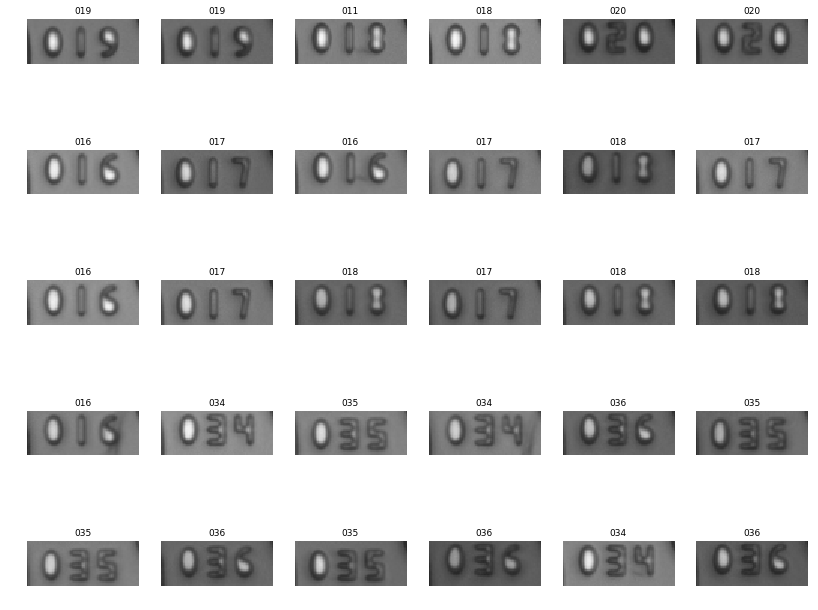

In [71]:
from mrcnn import visualize as mrcnn_viz
n = 30
#mrcnn_viz.display_images(df['st_num_image'].head(n), df['st_num'].head(n), cols=6)
mrcnn_viz.display_images(df['apt_num_image'].head(n), df['apt_num'].head(n), cols=6)

In [55]:
df.groupby(['date', 'cohort'])['cell_count'].describe().sort_index()

,,count,mean,std,min,25%,50%,75%,max
date,cohort,,,,,,,,
201805311610,NoDrug,13.0,4.230769,2.385856,2.0,3.00,3.0,5.00,11.0
201805311723,1nMQuiz,26.0,3.576923,1.301478,1.0,2.25,4.0,4.75,5.0
201805312109,NoDrug,26.0,3.307692,1.319674,1.0,2.00,4.0,4.00,5.0
201806011045,NoDrug,13.0,5.230769,0.926809,3.0,5.00,5.0,6.00,7.0
201806011129,1nMQuiz,20.0,4.950000,1.848897,2.0,4.00,5.0,5.00,10.0
201806012307,NoDrug,13.0,7.153846,2.192645,5.0,6.00,7.0,8.00,13.0
201806021115,1nMQuiz,26.0,4.692308,0.617688,3.0,4.00,5.0,5.00,6.0
201806021725,NoDrug,19.0,12.578947,6.752084,1.0,8.50,12.0,15.00,27.0
201806021800,1nMQuiz,13.0,5.000000,0.707107,4.0,5.00,5.0,5.00,6.0


### Debugging

In [47]:
# dataset = marker_dataset.MarkerDataset()
# dataset.initialize(data_files['path'].values)
# dataset.prepare()
# partitions, norm_image, norm_centers, neighbors, rotation, scale = apartment_extraction.extract(
#     image, marker_model, chip_config, 
#     digit_model=digit_model, cell_model=cell_model, 
#     chip_scaling=False
# )

In [34]:
#apartment_extraction.visualize_partition(partitions[0])